<a href="https://www.kaggle.com/code/kenny3s/iht-rehalf?scriptVersionId=166002662" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import shutil
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
from skimage import img_as_ubyte, io
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D#画3d图案所必需的

In [2]:
data_dir = '/kaggle/input/celeb-m/Celebrity Faces Dataset'

In [3]:
def block_no_expand(name):
    im=np.array(Image.open(name))
    im_lab=cv2.cvtColor(im,cv2.COLOR_RGB2HSV)
    im_lab[:,:,-1]=np.interp(im_lab[:,:,-1],(0,255),(0,255/4))
    im_rgb=cv2.cvtColor(im_lab,cv2.COLOR_HSV2RGB)
    im_ht=Image.fromarray(im_rgb).convert("1")
    im_ht=img_as_ubyte(im_ht)
    # gray_level(im_ht,(2,4),True)
    return im_ht

def find_best_params(gt_path):
    img = block_no_expand(gt_path)
    pil_halftone = Image.fromarray(img).convert('L').convert("1")
    halftone = img_as_ubyte(pil_halftone)
    ref = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    def IHT(radius=3, sigma_s=100, cnts=3):
        dehalftoned = halftone.copy()
        for i in range(cnts):
            dehalftoned = cv2.bilateralFilter(dehalftoned, radius, sigma_s, sigma_s)
        return dehalftoned

    best_psnr = 0
    best_params = None
    x = []
    y = []
    z = []
    w = []
    
    total_iterations = len(range(3, 20, 2)) * len(range(50,410,10)) * len(range(3, 10, 1))
    
    with tqdm(total=total_iterations) as pbar:
        for radius in range(3, 20, 2):
            for sigma_s in range(50,410,10):
                for cnts in range(3, 10, 1):
                    I = cv2.GaussianBlur(halftone.copy(), (radius, radius), 0)
                    dehalftoned = IHT(radius, sigma_s, cnts)
                    ehist = cv2.equalizeHist(dehalftoned)
                    psnr = peak_signal_noise_ratio(ehist, ref)
                    x.append(radius)
                    y.append(sigma_s)
                    z.append(cnts)
                    w.append(round(psnr, 4))
                    if psnr > best_psnr:
                        best_psnr = psnr
                        best_params = (radius, sigma_s, cnts)
                    pbar.update()
    return best_params, best_psnr,x,y,z,w

In [4]:
best_params, best_psnr,x,y,z,w = find_best_params(f'/kaggle/input/celeb-m/Celebrity Faces Dataset/0000.jpg')
print(f"Best_params:{best_params}, Best_PSNR:{best_psnr}")

100%|██████████| 2268/2268 [02:12<00:00, 17.17it/s]

Best_params:(5, 390, 4), Best_PSNR:20.849918555242294


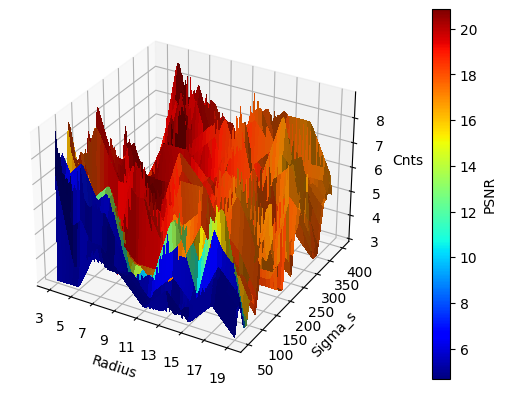

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib import cm
from matplotlib.colors import Normalize

# 假设你已经有了x, y, z, w的数据
# x, y, z, w = find_best_params(gt_path)

# 创建网格数据
xi = np.linspace(min(x), max(x), num=100)
yi = np.linspace(min(y), max(y), num=100)
xi, yi = np.meshgrid(xi, yi)

# 插值
wi = griddata((x, y), z, (xi, yi), method='linear')
wi_color = griddata((x, y), w, (xi, yi), method='linear')

# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xticks(np.arange(3, 20, 2))
ax.set_yticks(np.arange(50, 410, 50))
ax.set_zticks(np.arange(3, 10, 1))
# 创建颜色映射
cmap = cm.jet
norm = Normalize(vmin=np.min(w), vmax=np.max(w))

# 创建3D曲面图
surf = ax.plot_surface(xi, yi, wi, facecolors=cmap(norm(wi_color)), linewidth=0, antialiased=False)

# 添加颜色条并设置标签
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.12)
cbar.set_label('PSNR')

# 设置轴标签
ax.set_xlabel('Radius')
ax.set_ylabel('Sigma_s')
ax.set_zlabel('Cnts')

# 显示图形
plt.show()

In [ ]:
# with open('best_params.txt', 'w') as f:
#     f.write('id, cnts, radius, sigma_s\n')
#     for img in tqdm(os.listdir(data_dir)):
#         best_params, best_psnr= find_best_params(f'{data_dir}/{img}')
#         print(f"best_params:{best_params}---best_psnr:{best_psnr}")
#         f.write(f'{img[:-4]}, {best_params[0]}, {best_params[1]}, {best_params[2]}\n')